# Performance Analysis
In this Python notebook the algorithms will be assessed on their performance, more specifically the execution time of the algorithms will be analyzed.

In [20]:
# Libraries used in this python notebook
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import time

In [3]:
# These are the algorithms, which we are assessing
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for _ in range(n):
        goal_amnt = sum([int(random.random() < p_i) for p_i in p_is])
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

from poibin.poibin import PoiBin

def fft(p_is):
    return PoiBin(p_is).get_pmf_xi()

In [4]:
# Determine the maximum number of Possession xG values per team and match
xg_df = pd.read_pickle('possession_xGs.pkl')
xg_counts = xg_df.groupby('match_id').apply(lambda df: df.groupby('team_id')['team_id'].count()).sort_values()
max_n = xg_counts.max()
print(f'Maximum number of Possession xG per team and match is {max_n}')

Maximum number of Possession xG per team and match is 43


As a rule of thumb to get a representative value for the execution time we repeat the algorithm with the same input such that the average aggregate running time is 1 second.

In [5]:
REPEAT = 100
SIMULATION_RUNS = 10000
xg_counts = xg_counts.to_frame()
xg_counts.columns = ['xg_count']
xg_counts = xg_counts.reset_index()
for count in tqdm(np.sort(xg_counts['xg_count'].unique())):
    i_counts = xg_counts[xg_counts['xg_count'] == count]
    match_id = i_counts.sample()['match_id'].iat[0]
    team_id = i_counts[i_counts['match_id'] == match_id].sample()['team_id'].iat[0]
    p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()
    results = []
    execution_times_det = []
    execution_times_sim = []
    for _ in range(REPEAT):
        start = time.time() 
        results.append(dp(p_is))
        results.append(fft(p_is))
        stop = time.time()
        execution_times_det.append((stop - start)/2)
        start = time.time() 
        results.append(simulation(p_is, SIMULATION_RUNS))
        stop = time.time()
        execution_times_sim.append(stop - start)
print(f'Sum of runs for all algorithms is {len(results)}')
del results
print(f'Median Execution time of the deterministic algorithms is {np.median(execution_times_det)}s')
print(f'Average Execution time of the simulations is {np.average(execution_times_sim)}s')
n_reiterate_det = int(1/np.median(execution_times_det))+1
n_reiterate_sim = int(1/np.average(execution_times_sim))+1
print(f'Recommended number of reiterations for the determinitstic algorithms is {n_reiterate_det}')
print(f'Recommended number of reiterations for the simulation is {n_reiterate_sim}')

100%|██████████| 37/37 [01:27<00:00,  2.37s/it]

Sum of runs for all algorithms is 300
Median Execution time of the deterministic algorithms is 0.00017964839935302734s
Average Execution time of the simulations is 0.04966207981109619s
Recommended number of reiterations for the determinitstic algorithms is 5567
Recommended number of reiterations for the simulation is 21


Now we will assess the algorithms on our match data by measuring their execution time with the recommended amount of reiterations.

In [6]:
execution_times_dp = []
execution_times_fft = []
execution_times_sim = []
for count in tqdm(np.sort(xg_counts['xg_count'].unique())):
    i_counts = xg_counts[xg_counts['xg_count'] == count]
    match_id = i_counts.sample()['match_id'].iat[0]
    team_id = i_counts[i_counts['match_id'] == match_id].sample()['team_id'].iat[0]
    p_is = xg_df[(xg_df['match_id'] == match_id) & (xg_df['team_id'] == team_id)]['possession_xg'].to_list()
    results = []
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    execution_times_sim_agg = []
    for _ in range(n_reiterate_det):
        start = time.perf_counter_ns()
        results.append(dp(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(fft(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
    for _ in range(n_reiterate_sim):
        start = time.perf_counter_ns()
        results.append(simulation(p_is, SIMULATION_RUNS)) 
        stop = time.perf_counter_ns()
        execution_times_sim_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))
    execution_times_sim.append((count, execution_times_sim_agg))

100%|██████████| 37/37 [00:47<00:00,  1.28s/it]


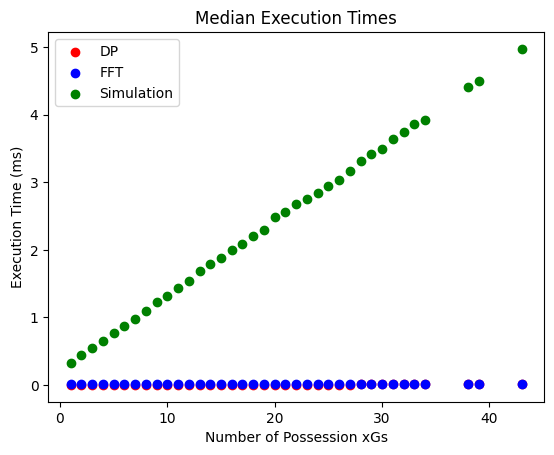

In [7]:
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1])/10e6 for t in execution_times_dp], c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1])/10e6 for t in execution_times_fft], c='blue', label='FFT')
plt.scatter([t[0] for t in execution_times_sim], [np.median(t[1])/10e6 for t in execution_times_sim], c='green', label='Simulation')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.show()

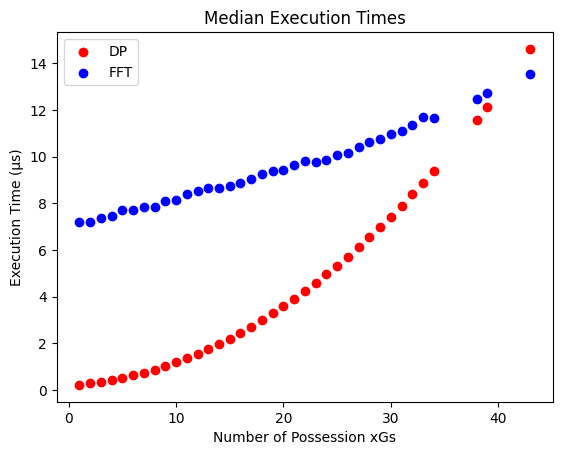

In [8]:
plt.clf()
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1])/10e3 for t in execution_times_dp], c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1])/10e3 for t in execution_times_fft], c='blue', label='FFT')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

The execution times for the DP and FFT algorithm seem to intersect at around 40 $p_i$'s. To analyze this further we can sample from the empirical distribution from the Possession xGs up to 100 $p_i$'s.

In [9]:
# TODO: Sample from Possession xG to further Analyze this and then put a linear regression to find out the constants
execution_times_dp = []
execution_times_fft = []
N = 100
for count in tqdm(range(1, N+1)):
    p_is = xg_df.sample(count, replace=True)['possession_xg'].to_list()
    results = []
    execution_times_dp_agg = []
    execution_times_fft_agg = []
    execution_times_sim_agg = []
    for _ in range(n_reiterate_det):
        start = time.perf_counter_ns()
        results.append(dp(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_dp_agg.append(stop - start)
        start = time.perf_counter_ns()
        results.append(fft(p_is)) 
        stop = time.perf_counter_ns()
        execution_times_fft_agg.append(stop - start)
    execution_times_dp.append((count, execution_times_dp_agg))
    execution_times_fft.append((count, execution_times_fft_agg))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


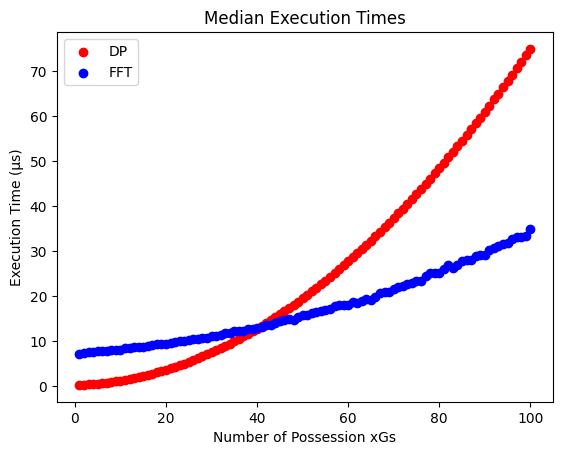

In [10]:
plt.clf()
plt.scatter([t[0] for t in execution_times_dp], [np.median(t[1])/10e3 for t in execution_times_dp], c='red', label='DP')
plt.scatter([t[0] for t in execution_times_fft], [np.median(t[1])/10e3 for t in execution_times_fft], c='blue', label='FFT')
plt.title('Median Execution Times')
plt.xlabel('Number of Possession xGs')
plt.ylabel('Execution Time (µs)')
plt.legend()
plt.show()

The DP algorithm has asymptotic runtime $\mathcal{\Theta}(n^2)$, while the FFT algorithm has the asymptotic runtime $\mathcal{\Theta}(n \cdot \log(n))$. Let's now fit the following functions to the execution times:
- DP: $an^2 + bn + c$
- FFT: $dn \cdot \log(n) + en + f$
Where $n$ is the number of $p_i$'s which the algorithms get as input.

In [29]:
# Fit to the DP execution times
dp_x = []
for n, times in execution_times_dp:
    dp_x.append([n] * len(times))
dp_x = np.array(sum(dp_x, []))
dp_y = np.array(sum([t[1] for t in execution_times_dp], []))
dp_poly = PolynomialFeatures(degree=2, include_bias=False)
dp_poly_features = dp_poly.fit_transform(dp_x.reshape(-1, 1))
dp_poly_reg_model = LinearRegression()
dp_poly_reg_model.fit(dp_poly_features, dp_y)
dp_y_predicted = dp_poly_reg_model.predict(dp_poly_features)
print(f'DP Regression Model coefficients: {dp_poly_reg_model.coef_}, y_Intercept: {dp_poly_reg_model.intercept_}')

DP Regression Model coefficients: [248.51915112  72.30074967], y_Intercept: 2200.54095444578
